# Import Data

In [1]:
import os
import researchpy as rp
import pandas as pd
import pickle

import statsmodels.api as sm
from statsmodels.formula.api import ols

dataset_pickle = 'data/dataset.pickle'

with open(dataset_pickle, 'rb') as handle:
    df = pickle.load(handle)

assert df is not None, f'The dataset pickle file {dataset_pickle} is not found'

        
acc_df = pd.DataFrame({'y': df["accuracy"],
                       'epochs': df["max_epochs"],
                       'memory': df["executor_memory"],
                       'cores': df["executor_cores"],
                       'model': df["model"]})

time_df = pd.DataFrame({'y': df["time"],
                        'epochs': df["max_epochs"],
                        'memory': df["executor_memory"],
                        'cores': df["executor_cores"],
                        'model': df["model"]})

print(f"Imported {len(dataset_pickl)} experiments!")

NameError: name 'dataset_pickl' is not defined

## DataFrame Summaries

In [2]:
summary_acc_df = rp.summary_cont(acc_df.groupby(['model', 'epochs', 'cores', 'memory']))['y']
summary_acc_df

N    Mean      SD      SE  95% Conf.  Interval
model  epochs cores memory                                                
bi-rnn 20     8     4       5  0.3995  0.0106  0.0048     0.3863    0.4127
                    32      5  0.4163  0.0203  0.0091     0.3911    0.4416
              16    4       5  0.4103  0.0139  0.0062     0.3931    0.4275
                    32      5  0.4074  0.0075  0.0033     0.3981    0.4167
       40     8     4       5  0.5384  0.0260  0.0116     0.5062    0.5707
                    32      5  0.5719  0.0276  0.0124     0.5376    0.6062
              16    4       5  0.5741  0.0587  0.0263     0.5012    0.6471
                    32      5  0.5601  0.0370  0.0166     0.5142    0.6061
       60     8     4       5  0.7198  0.0334  0.0149     0.6784    0.7613
                    32      5  0.7261  0.0327  0.0146     0.6855    0.7668
              16    4       5  0.7159  0.0595  0.0266     0.6420    0.7897
                    32      5  0.7497  0.0336  0.0150     0.7080    0.7914
lenet5 20     8     4       5  0.9323  0.0023  0.0010     0.9294    0.9351
                    32      5  0.9351  0.0034  0.0015     0.9309    0.9392
              16    4       5  0.9356  0.0063  0.0028     0.9278    0.9434
                    32      5  0.9338  0.0009  0.0004     0.9326    0.9349
       40     8     4       5  0.9539  0.0035  0.0016     0.9495    0.9582
                    32      5  0.9528  0.0036  0.0016     0.9484    0.9573
              16    4       5  0.9529  0.0054  0.0024     0.9462    0.9596
                    32      5  0.9536  0.0014  0.0006     0.9519    0.9553
       60     8     4       5  0.9584  0.0014  0.0006     0.9567    0.9601
                    32      5  0.9604  0.0013  0.0006     0.9589    0.9620
              16    4       5  0.9596  0.0022  0.0010     0.9568    0.9623
                    32      5  0.9599  0.0034  0.0015     0.9556    0.9641

In [3]:
summary_time_df = rp.summary_cont(time_df.groupby(['model', 'epochs', 'cores', 'memory']))['y']
summary_time_df

N       Mean        SD       SE  95% Conf.  \
model  epochs cores memory                                               
bi-rnn 20     8     4       5   347.3691   28.0840  12.5596   312.4982   
                    32      5   345.7391   20.0969   8.9876   320.7855   
              16    4       5   308.6550   34.6991  15.5179   265.5704   
                    32      5   308.1720   38.2285  17.0963   260.7050   
       40     8     4       5   682.8385   38.0844  17.0319   635.5505   
                    32      5   677.2253   29.9156  13.3787   640.0802   
              16    4       5   607.7823   39.6965  17.7528   558.4926   
                    32      5   620.8618   30.3143  13.5570   583.2216   
       60     8     4       5   996.7127   64.3048  28.7580   916.8677   
                    32      5  1008.8503   65.0580  29.0948   928.0701   
              16    4       5   888.7607   91.2986  40.8300   775.3985   
                    32      5   895.5210  114.3337  51.1316   753.5570   
lenet5 20     8     4       5   174.9143   11.3552   5.0782   160.8149   
                    32      5   175.6735   10.5155   4.7027   162.6167   
              16    4       5   172.4267   12.4227   5.5556   157.0019   
                    32      5   173.4769   12.0750   5.4001   158.4838   
       40     8     4       5   335.0642   20.0839   8.9818   310.1267   
                    32      5   334.3299   13.6900   6.1223   317.3315   
              16    4       5   330.8454   14.2473   6.3716   313.1551   
                    32      5   330.2939   14.7607   6.6012   311.9662   
       60     8     4       5   498.6016   28.5953  12.7882   463.0958   
                    32      5   499.8644   29.9425  13.3907   462.6859   
              16    4       5   492.1793   30.3675  13.5808   454.4731   
                    32      5   494.0800   28.4499  12.7232   458.7548   

                             Interval  
model  epochs cores memory             
bi-rnn 20     8     4        382.2400  
                    32       370.6927  
              16    4        351.7397  
                    32       355.6390  
       40     8     4        730.1265  
                    32       714.3704  
              16    4        657.0720  
                    32       658.5019  
       60     8     4       1076.5576  
                    32      1089.6304  
              16    4       1002.1229  
                    32      1037.4850  
lenet5 20     8     4        189.0136  
                    32       188.7302  
              16    4        187.8515  
                    32       188.4700  
       40     8     4        360.0017  
                    32       351.3282  
              16    4        348.5357  
                    32       348.6217  
       60     8     4        534.1074  
                    32       537.0429  
              16    4        529.8855  
                    32       529.4052

## ANOVA analysis

In [4]:
def anova_analysis(input_df):
    model = ols('y ~ C(model)*epochs*cores*memory', input_df).fit()
    
    res = sm.stats.anova_lm(model, typ=2)
    res['PR(>F) < 0.05'] = res['PR(>F)'] < 0.05
    return res, model

In [5]:
acc_res, acc_model = anova_analysis(acc_df)
print("Accuracy ANOVA Analysis")
acc_res

Accuracy ANOVA Analysis


,sum_sq,df,F,PR(>F),PR(>F) < 0.05
C(model),4.405344,1.0,7678.538858,2.771223e-99,True
epochs,0.594763,1.0,1036.674883,6.699539e-56,True
C(model):epochs,0.432548,1.0,753.932839,1.845180e-49,True
cores,0.000479,1.0,0.835249,3.628731e-01,False
C(model):cores,0.000387,1.0,0.675173,4.131336e-01,False
epochs:cores,0.000083,1.0,0.144718,7.044104e-01,False
C(model):epochs:cores,0.000114,1.0,0.199541,6.560202e-01,False
memory,0.001221,1.0,2.128440,1.476016e-01,False
C(model):memory,0.001038,1.0,1.809952,1.814401e-01,False
epochs:memory,0.000238,1.0,0.415524,5.205983e-01,False


In [6]:
time_res, time_model = anova_analysis(time_df)
print("Time ANOVA Analysis")
time_res

Time ANOVA Analysis


,sum_sq,df,F,PR(>F),PR(>F) < 0.05
C(model),2.816333e+06,1.0,1665.642874,7.960799e-66,True
epochs,4.437158e+06,1.0,2624.234746,1.319897e-75,True
C(model):epochs,4.437783e+05,1.0,262.460426,3.308092e-30,True
cores,4.296497e+04,1.0,25.410449,1.966833e-06,True
C(model):cores,3.397583e+04,1.0,20.094070,1.902304e-05,True
epochs:cores,7.269732e+03,1.0,4.299483,4.059484e-02,True
C(model):epochs:cores,5.906269e+03,1.0,3.493100,6.443885e-02,False
memory,1.626118e+02,1.0,0.096172,7.570929e-01,False
C(model):memory,8.809884e+01,1.0,0.052104,8.198906e-01,False
epochs:memory,1.563117e+02,1.0,0.092446,7.616975e-01,False


In [7]:
epoch_model_acc = ols('epochs ~ C(model)*cores*memory*y', acc_df).fit()
epoch_model_time = ols('epochs ~ C(model)*cores*memory*y', time_df).fit()

def epoch_model_predict(trained_model, model, cores, memory, y):
    assert model.lower() in ['bi-rnn', 'lenet5'], 'unsupported model (supported: bi-rnn or lenet5)'
    assert cores > 0, 'impossible to run on 0 cores'
    assert memory > 0, 'impossible to run without memory'
    assert y > 0, 'either time or accuracy should be >0 (time or accuracy depends on the trained model)'
    return trained_model.predict(exog={'model': model.lower(), 'cores': cores, 'memory': memory, 'y': y})[0]

In [8]:
prediction_with_acc = epoch_model_predict(epoch_model_acc, model='Bi-rnn', cores=10, memory=64, y=0.6)
prediction_with_time = epoch_model_predict(epoch_model_time, model='Bi-rnn', cores=10, memory=64, y=300)

print(f'Predicted epochs with accuracy: {prediction_with_acc}')
print(f'Predicted epochs with time: {prediction_with_time}')

Predicted epochs with accuracy: 41.363562433696885
Predicted epochs with time: 18.67160826394011


In [ ]:
def calculate_percentages_variation_explained(acc_model, time_model):
    df_time_test = sm.stats.anova_lm(time_model, typ=1)[['sum_sq']]
    df_acc_test = sm.stats.anova_lm(acc_model, typ=1)[['sum_sq']]

    df_acc_test['Percentage of variation explained (accuracy)'] = df_acc_test['sum_sq']/df_acc_test['sum_sq'].sum() * 100
    df_time_test['Percentage of variation explained (time)'] = df_time_test['sum_sq']/df_time_test['sum_sq'].sum() * 100

    df_acc_test = df_acc_test.drop('sum_sq', axis=1)
    df_acc_test['Percentage of variation explained (time)'] = df_time_test['Percentage of variation explained (time)']
    df_acc_test['Percentage of variation explained (accuracy)'] = df_acc_test['Percentage of variation explained (accuracy)'].apply(lambda x: f'{x:.2f}%')
    df_acc_test['Percentage of variation explained (time)'] = df_acc_test['Percentage of variation explained (time)'].apply(lambda x: f'{x:.2f}%')
    return df_acc_test

## Check normality of errors

9.251089477801955e-13
Sample does not look Gaussian (reject H0)
mean=0.004 stdv=0.034


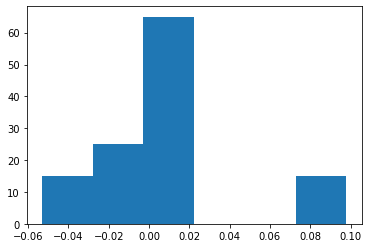

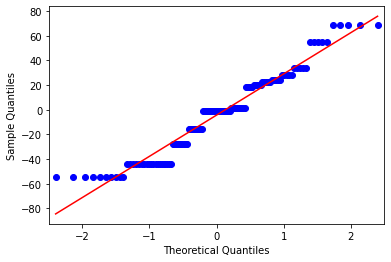

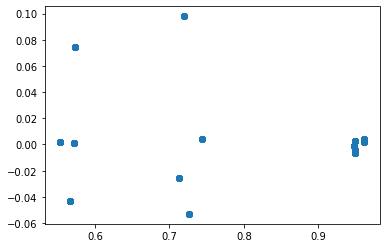

In [103]:
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from numpy import *
import matplotlib.pyplot as plt
import numpy as np

acc_df_extra = acc_df.copy()

for i, row in acc_df.iterrows():
    y_pred = acc_model.predict(exog={
        'epochs': row['epochs'] ,
        'model': row['model'], 
        'cores': row['cores'], 
        'memory': row['memory']
    })[0]
    error = y_pred - row['y'] 
    
    acc_df_extra.at[i,'y_pred'] = y_pred
    acc_df_extra.at[i,'error'] = error

# SHAPIRO TEST
# data = 200 * randn(100) + 50
data = acc_df_extra['error']
stat, p = stats.shapiro(data)

alpha = 0.05
print(p)
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

# HISTOGRAM
data = acc_df_extra['error']
print('mean=%.3f stdv=%.3f' % (mean(data), std(data)))
pyplot.hist(data, bins=6)
pyplot.show()

# QQ
data = time_df_extra['error']
qqplot(data, line='s')
pyplot.show()

# Scatter
pyplot.scatter(acc_df_extra['y_pred'], acc_df_extra['error'])
pyplot.show()

